In [16]:
%matplotlib notebook

import numpy as np
import scipy
import h5py
from scipy import optimize
from scipy import interpolate
import matplotlib as mpl
from matplotlib import pyplot as plt
import math
import pandas as pd
from pathlib import Path
import os
import os.path
from scipy.interpolate import interp1d
import sys
import datetime
import lmfit
from lmfit import *

sys.path.insert(0, '../201207/')
# rate_model script model different droplet shape fractions as a function of time
from time_dependent_model import rate_model
from scipy.interpolate import RegularGridInterpolator

import warnings
warnings.simplefilter('always', DeprecationWarning)
warnings.filterwarnings('ignore')

In [17]:
# linear fit y= mx+b, y_intercept b = y - mx
def slope_and_intercept(xs,ys):
    m = ((np.mean(xs) * np.mean(ys)) - np.mean(xs * ys))/ ((np.mean(xs) * np.mean(xs)) - np.mean(xs * xs))
    b = np.mean(ys) - (m * np.mean(xs))
    return m,b

In [18]:
# constants and functions
N_A = 6.0221367e23 # molecules/mol
m_h2o = 2*1.00794+15.9995 # g/mol
kB = 1.380649e-23 # J/K
# thermodynamic functions from Kell, Journal of Chemical Engineering Data 20, 97 (1975)
# ----
# density
rho_h2o_si = lambda den_t : (933.942 + 66.7829 / (1.0 + np.exp( - 0.10662 * (den_t - 233.0573)))) / 1000 # g/cm^3
rho_h2o = lambda T : rho_h2o_si(T)*N_A/1e24/m_h2o # molecule/A^3
vol_h2o = lambda T : 1e-30/rho_h2o(T) # m^3/molecule

# thermodynamic functions from Laksmono et al. JPCL (2014)
# ----
# density
rho_ice_si = lambda T : (-1.3103e-9*T*T*T + 3.8109e-7*T*T - 9.259e-5*T + 0.94040) # g/cm^3
rho_ice = lambda T : rho_ice_si(T)*N_A/1e24/m_h2o # molecule/A^3
vol_ice = lambda T : 1e-30/rho_ice(T) # m^3/molecule
#rho_ice = 0.917 # g/cm3, from wikipedia
#rho_ice = 0.934 # g/cm3, from evapcool

# droplet radius
R_droplet = 20e-6/10 # m

# saturation vapor pressure
psat_water = lambda T : np.exp(54.842763 - 6763.22/T - 4.210*np.log(T) + 0.000367*T + np.tanh(0.0415*(T-218.8))*(53.878-1331.22/T- 9.44523*np.log(T) + 0.014025*T)) # Pa
psat_hexice = lambda T : np.exp(9.550426 - 5723.265/T + 3.53068*np.log(T) - 0.00728332*T) # Pa
psat_ice = lambda T : psat_hexice(T)*np.exp(155/(N_A*kB*T))
S = lambda T : psat_water(T)/psat_ice(T)

# diffusivity
D_laksmono = lambda T_arr : 1.67e-8*np.exp(5.698332e-2*T_arr*T_arr - 2.728998e1*T_arr + 3.271878e3) # m^2/s, WRONG? off by e-5
D_VFT = lambda T_arr : 4.14e-8*np.exp(-347./(T_arr-177.)) # m^2/s
D_PL = lambda T_arr : 1.67e-8*(T_arr/223. - 1.)**1.82 # m^2/s

# interfacial free energy (surface tension)
sigma_vapor = lambda T : (111.63 - 0.13167*T)/1000 # J/m^2
sigma_MH = lambda T : (20.8*(T/235.8)**0.3)/1000 # J/m^2
sigma_laksmono_VFT = lambda T_arr : 1.198100169422e-11*T_arr**6 - 1.644226732545e-8*T_arr**5 + 9.387801708449e-6*T_arr**4 - 2.854359440278e-3*T_arr*T_arr*T_arr + 4.874466166395e-1*T_arr*T_arr - 4.433154987346e1*T_arr + 1.677613823216e3 # J/m^2
sigma_laksmono_PL = lambda T_arr : -6.238115076579e-10*T_arr**6 + 8.736769546436e-7*T_arr**5 - 5.098181318142e-4*T_arr**4 + 1.586558905910e-1*T_arr*T_arr*T_arr - 2.777134850571e1*T_arr*T_arr + 2.592466463405e3*T_arr - 1.008309560689e5 # J/m^2
#sigma_fit_pol = lambda T_arr, a, b, c, d, e, f, g : a*T_arr**6 + b*T_arr**5 + c*T_arr**4 + d*T_arr*T_arr*T_arr + e*T_arr*T_arr + f*T_arr + g
#sigma_fit_lin = lambda T_arr, k, m : k*T_arr + m
sigma_from_J = lambda T, J, D, sigma0 : np.cbrt((np.log(J_0(T, D, sigma0))-np.log(J))*3*deltamu(T)*deltamu(T)*kB*T/(16*np.pi*vol_ice(T)*vol_ice(T)))
# use np.polyfit, np.polyval

# chemical potential difference
deltamu_0 = lambda T : -kB*T*np.log(S(T))
#deltamu_P = lambda T : 0
deltamu_P = lambda T : (psat_water(T) + 2*sigma_vapor(T)/R_droplet - psat_ice(T))*vol_ice(T) - (2*sigma_vapor(T)/R_droplet)*vol_h2o(T) # chemical potential from Laplace pressure
deltamu = lambda T : deltamu_0(T) + deltamu_P(T)

# free energy barriers
deltaF = lambda T, sigma : 16*np.pi*sigma*sigma*sigma*vol_ice(T)*vol_ice(T)/(3*deltamu(T)*deltamu(T)) # J/molecule
deltaf = lambda T, D : -kB*np.gradient(np.log(D), 1/T) # J/molecule

# nucleation rate
J_0 = lambda T, D, sigma : (16*np.cbrt(3*np.pi/4)*np.sqrt(sigma/kB/T)*D/np.cbrt(vol_ice(T))**4)
J = lambda T, D, sigma : J_0(T, D, sigma)*np.exp(-deltaF(T, sigma)/kB/T)

In [19]:
# experimental diffusivity data from SwissFEL
data_SwissFEL = np.loadtxt('/Users/niloo/Desktop/Lab_data/altogether/diffusion/ver3/entropy_data_7.2.csv', delimiter=',')
T_SwissFEL = np.array([data_SwissFEL[i,0] for i in range(len(data_SwissFEL))])
D_SwissFEL = np.array([data_SwissFEL[i,13] for i in range(len(data_SwissFEL))])
D_SwissFEL_invT = interpolate.InterpolatedUnivariateSpline(1/T_SwissFEL, D_SwissFEL)
p_SwissFEL = np.polyfit(T_SwissFEL, D_SwissFEL, 6, rcond=None, full=False, w=None, cov=False)
p_SwissFEL_invT_log = np.polyfit(1/T_SwissFEL, np.log(D_SwissFEL), 6, rcond=None, full=False, w=None, cov=False)
D_SwissFEL_fit = lambda T: np.polyval(p_SwissFEL, T)
D_SwissFEL_fit_log = lambda T: np.exp(np.polyval(p_SwissFEL_invT_log, 1/T))

In [20]:
# data from lab experiments (Mar-Dec 2020)
file_dir = "/Users/niloo/Desktop/manuscript/final_files_lab_paper/Finding_droplets-master/Examples/"
data1 = np.loadtxt(file_dir + 'Results_MC/Mar_12_with_types_measuredpos.txt')

# Mar 12 2020 (2020, 3, 12, 0, 0)
time1 = data1[:,1]
T1_MC = data1[:,4]
J1_MC = data1[:,-3]
T1_MC_low = data1[:,5]
T1_MC_high = data1[:,6]
J1_MC_low = data1[:,-2]
J1_MC_high = data1[:,-1]
# counts
# the count data is available in an excel sheet saved on Google Drive which can be downloaded in the desired path
df1 = pd.read_excel(r'/Users/niloo/Desktop/Lab_data/201207/CountingData.xlsx')
ntot1 = df1['total focused droplets'].dropna().values
nmarbles1 = df1['rippling (focused)'].dropna().values # now we call 'rippling' group as partially frozen or marbles 
nblobs1 = df1['side-blobs (focused)'].dropna().values # now we call side-blobs as liquid extrusion
nfract1 = df1['fractured/collided (focused)'].dropna().values
ndist1 = df1['distorted (focused)'].dropna().values
distance1 = df1['distances (mm)'].dropna().values* 0.001 # in m

nwater1 = ntot1 - (nmarbles1+nblobs1+nfract1+ndist1)
# fractions
fice1 = (nmarbles1 + nblobs1 + nfract1 + ndist1)/ntot1.astype(np.float)
fmarbles1 = nmarbles1/ntot1.astype(np.float)
fblobs1 = nblobs1/ntot1.astype(np.float)
ffract1 = nfract1/ntot1.astype(np.float)
fdist1 = ndist1/ntot1.astype(np.float)
#nucleation rate
# read the excel sheet with the droplet size and volume on Google Drive
df1 = pd.read_excel(r'/Users/niloo/Desktop/manuscript/final_files_lab_paper/Droplet_calculations.xlsx', skiprows=[0,0]) 
experiment_tag = df1['Day'].values # The experiment is tagged by the date of the experiment (year, month, day, hour, min), look at the time in excel sheet to understand this.
d1 = df1['Average droplet diameter (um)'].values[np.where(experiment_tag == datetime.datetime(2020, 3, 12, 0, 0))]*1e-6 #m (convert um to m)
V1 = df1['Average droplet volume (um^3)'].values[np.where(experiment_tag == datetime.datetime(2020, 3, 12, 0, 0))]*1e-18 # m^3 (convert um3 to m3)
#-----------------------------------------------------------------------

# Nov 3 2020 (2020, 11, 3, 0, 0)

data2 = np.loadtxt(file_dir + 'Results_MC/Nov_3_with_types_measuredpos.txt')

time2 = data2[:,1]
T2_MC = data2[:,4]
J2_MC = data2[:,-3]
T2_MC_low = data2[:,5]
T2_MC_high = data2[:,6]
J2_MC_low = data2[:,-2]
J2_MC_high = data2[:,-1]

# counts
# the count data is available in an excel sheet saved on Google Drive which can be downloaded in the desired path
df2 = pd.read_excel(r'/Users/niloo/Desktop/Lab_data/201207/CountingData.xlsx', sheet_name="Nov2020") 
ntot2 = df2['total focused droplets'].dropna().values
nmarbles2 = df2['rippling (focused)'].dropna().values # now we call 'rippling' group as partially frozen or marbles 
nblobs2 = df2['side-blobs (focused)'].dropna().values # now we call side-blobs as liquid extrusion
nfract2 = df2['fractured (focused)'].dropna().values
ndist2 = df2['distorted (focused)'].dropna().values
nwater2 = ntot2 - (nmarbles2+nblobs2+nfract2+ndist2)
distance2= df2['distances (mm)'].dropna().values* 0.001 # in m
# fractions
fice2 = (nmarbles2 + nblobs2 + nfract2 + ndist2)/ntot2.astype(np.float)
fmarbles2 = nmarbles2/ntot2.astype(np.float)
fblobs2 = nblobs2/ntot2.astype(np.float)
ffract2 = nfract2/ntot2.astype(np.float)
fdist2 = ndist2/ntot2.astype(np.float)
#nucleation rate
# read the excel sheet with the droplet size and volume on Google Drive
d2 = df1['Average droplet diameter (um)'].values[np.where(experiment_tag == datetime.datetime(2020, 11, 3, 0, 0))]*1e-6 #m (convert um to m)
V2 = df1['Average droplet volume (um^3)'].values[np.where(experiment_tag == datetime.datetime(2020, 11, 3, 0, 0))]*1e-18 # m^3 (convert um3 to m3)
#-----------------------------------------------------------------------

# Dec 7 2020 (2020, 12, 7, 0, 0)
data3 = np.loadtxt(file_dir + 'Results_MC/Dec_7_with_types_measuredpos.txt')

# last datapoint with fice=1 excluded
time3 = data3[:,1]
T3_MC = data3[:,4]
J3_MC = data3[:,-3]
T3_MC_low = data3[:,5]
T3_MC_high = data3[:,6]
J3_MC_low = data3[:,-2]
J3_MC_high = data3[:,-1]

# counts
# the count data is available in an excel sheet saved on Google Drive which can be downloaded in the desired path
df3 = pd.read_excel(r'/Users/niloo/Desktop/Lab_data/201207/7_dec2020.xlsx') 
ntot3 = df3['useful cutouts'].dropna().values
nmarbles3 = df3['Marbles'].dropna().values # now we call 'rippling' group as partially frozen or marbles 
nblobs3 = df3['Sideblobs'].dropna().values # now we call side-blobs as liquid extrusion
nfract3 = df3['Fractured'].dropna().values
nwater3 = ntot3 - (nmarbles3+nblobs3+nfract3)
distance3 = df3['distance (mm)'].dropna().values* 0.001 # in m

# fractions
fice3 = (nmarbles3 + nblobs3 + nfract3 )/ntot3.astype(np.float)
fice3 = np.delete(fice3, np.where(fice3 == 1)) # remove ice fraction if it equals to 1.
fmarbles3 = nmarbles3/ntot3.astype(np.float)
fblobs3 = nblobs3/ntot3.astype(np.float)
ffract3 = nfract3/ntot3.astype(np.float)

#nucleation rate
# read the excel sheet with the droplet size and volume on Google Drive
d3 = df1['Average droplet diameter (um)'].values[np.where(experiment_tag == datetime.datetime(2020, 12, 7, 0, 0))]*1e-6 #m (convert um to m)
V3 = df1['Average droplet volume (um^3)'].values[np.where(experiment_tag == datetime.datetime(2020, 12, 7, 0, 0))]*1e-18 # m^3 (convert um3 to m3)

#-----------------------------------------------------------------------

# May 11 2021 (2021, 5, 5, 0, 0)
data4 = np.loadtxt(file_dir + 'Results_MC/May_11_2021_measuredpos.txt')

time4 = data4[:,1]
T4_MC = data4[:,4]
J4_MC = data4[:,-3]
T4_MC_low = data4[:,5]
T4_MC_high = data4[:,6]
J4_MC_low = data4[:,-2]
J4_MC_high = data4[:,-1]

# counts
# the count data is available in an excel sheet saved on Google Drive which can be downloaded in the desired path
df4 = pd.read_excel(r'/Users/niloo/Desktop/Lab_data/laser-induced/Laser-induced.xlsx',  sheet_name="reanalyze")
nwater4= df4['water'].dropna().values[:4]
nmarbles4 = df4['marbles'].dropna().values[:4] # now we call 'rippling' group as partially frozen or marbles 
nblobs4 = df4['blobs'].dropna().values[:4] # now we call side-blobs as liquid extrusion
nfract4 = df4['fractured'].dropna().values[:4]
ntot4 = nwater4+ nmarbles4 + nblobs4 + nfract4
distance4 = df4['distance (mm)'].dropna().values[:4]* 0.001 # in m

# fractions
fice4 = (nmarbles4 + nblobs4 + nfract4 )/ntot4.astype(np.float)
fice4 = np.delete(fice4, np.where(fice4 == 1)).astype(float) # remove ice fraction if it equals to 1.
fmarbles4 = nmarbles4/ntot4.astype(np.float)
fblobs4 = nblobs4/ntot4.astype(np.float)
ffract4 = nfract4/ntot4.astype(np.float)

#nucleation rate
# read the excel sheet with the droplet size and volume on Google Drive
d4 = df1['Average droplet diameter (um)'].values[np.where(experiment_tag == datetime.datetime(2021, 5, 5, 0, 0))]*1e-6 #m (convert um to m)
V4 = df1['Average droplet volume (um^3)'].values[np.where(experiment_tag == datetime.datetime(2021, 5, 5, 0, 0))]*1e-18 # m^3 (convert um3 to m3)
#-----------------------------------------------------------------------
# Altogether (all experiments together)

time = np.hstack([time1, time2, time3, time4]).astype(float)
setindex = np.array([len(time1), len(time1)+len(time2), len(time1)+len(time2)+len(time3), len(time1)+len(time2)+len(time3)+len(time4)])
fice = np.hstack([fice1, fice2, fice3, fice4]).astype(float)
fmarbles = np.hstack([fmarbles1, fmarbles2, fmarbles3[:-1], fmarbles4]).astype(float) # last datapoint with fice=1 excluded
fblobs = np.hstack([fblobs1, fblobs2, fblobs3[:-1], fblobs4]).astype(float) # last datapoint with fice=1 excluded
ffractdist = np.hstack([ffract1+fdist1, ffract2+fdist2, ffract3[:-1], ffract4]).astype(float) # last datapoint with fice=1 excluded
J_tot = np.hstack([J1_MC, J2_MC, J3_MC, J4_MC]).astype(float)
G = np.hstack([J1_MC*V1, J2_MC*V2, J3_MC*V3, J4_MC*V4]).astype(float)
V = np.hstack([V1, V2, V3, V4]).astype(float)




In [21]:
#Literature data from different references
# Read the excel file to load Laksmono et aL 2015 data
df_l = pd.read_excel(r'/Users/niloo/Desktop/Lab_data/201207/CountingData.xlsx',  sheet_name="LaksmonoJPCL2015", skiprows=[0,0])
T_laksmono = df_l['Average temperature (K)'].dropna().values
# Remove elements that are in txt form
T_laksmono = np.delete(T_laksmono, np.where([type(T_laksmono[i]) == str for i in range(len(T_laksmono))]))
T_laksmono_high = df_l['T_error_max (K)'].dropna().values
# Remove elements that are in txt form
T_laksmono_high = np.delete(T_laksmono_high, np.where([type(T_laksmono_high[i]) == str for i in range(len(T_laksmono_high))]))
T_laksmono_low = df_l['T_error_min (K)'].dropna().values
# Remove elements that are in txt form
T_laksmono_low = np.delete(T_laksmono_low, np.where([type(T_laksmono_low[i]) == str for i in range(len(T_laksmono_low))]))

J_laksmono = df_l['Nucleation rate (cm^-3/s)'].dropna().values
# Remove elements that are in txt form
J_laksmono = np.delete(J_laksmono, np.where([type(J_laksmono[i]) == str for i in range(len(J_laksmono))]))*1e6
J_laksmono = J_laksmono.astype(np.float)
J_laksmono_low = df_l['J error min (cm^-3/s)'].dropna().values
# Remove elements that are in txt form
J_laksmono_low = np.delete(J_laksmono_low, np.where([type(J_laksmono_low[i]) == str for i in range(len(J_laksmono_low))]))*1e6
J_laksmono_low = J_laksmono_low.astype(np.float)
J_laksmono_high = df_l['J error max (cm^-3/s)'].dropna().values
# Remove elements that are in txt form
J_laksmono_high = np.delete(J_laksmono_high, np.where([type(J_laksmono_high[i]) == str for i in range(len(J_laksmono_high))]))*1e6
J_laksmono_high = J_laksmono_high.astype(np.float)

In [22]:
# Experimental data from Murray's group

# load Murray 2010 data Run1
data_dir = "/Users/niloo/Desktop/manuscript/final_files_lab_paper/Finding_droplets-master/altogether/"

# load Tarn et al 2021 (latest publication)
Run1 = np.loadtxt(data_dir + 'Murray_dataset/Murray_Run1.txt')
Run2 = np.loadtxt(data_dir + 'Murray_dataset/Murray_Run2.txt')
Run3 = np.loadtxt(data_dir + 'Murray_dataset/Murray_Run3.txt')

# Run 1
T_Murray_R1 = Run1[:,0] + 273.
T_R1_err = Run1[:,1]
J_Murray_R1 = Run1[:,2]*10**6
J_R1_up = Run1[:,3]*10**6
J_R1_down = Run1[:,4]*10**6

# Run 2
T_Murray_R2 = Run2[:,0] + 273.
T_R2_err = Run2[:,1]
J_Murray_R2 = Run2[:,2]*10**6
J_R2_up = Run2[:,3]*10**6
J_R2_down = Run2[:,4]*10**6

# Run 3
T_Murray_R3 = Run3[:,0] + 273.
T_R3_err = Run3[:,1]
J_Murray_R3 = Run3[:,2]*10**6
J_R3_up = Run3[:,3]*10**6
J_R3_down = Run3[:,4]*10**6

In [23]:
#old fits from Niloo saved as numpy arrays for PhD thesis
n4_sym_old = np.load('/Users/niloo/Desktop/manuscript/final_files_lab_paper/sym_4th.npy')[::-1]
n6_sym_old = np.load('/Users/niloo/Desktop/manuscript/final_files_lab_paper/sym_6th.npy')[::-1]
n6_asym_old = np.load('/Users/niloo/Desktop/manuscript/final_files_lab_paper/asym_6th.npy')[::-1]
n6_uw_old = np.load('/Users/niloo/Desktop/manuscript/final_files_lab_paper/unweighted_6th.npy')[::-1]

In [24]:
T_thres = 243
J_thres = 1e15
# update code below with threshold parameters
T1_MC_ex = T1_MC[(T1_MC < T_thres) & (J1_MC > J_thres)]
T2_MC_ex = T2_MC[(T2_MC < T_thres) & (J2_MC > J_thres)]
T3_MC_ex = T3_MC[(T3_MC < T_thres) & (J3_MC > J_thres)]
T4_MC_ex = T4_MC[(T4_MC < T_thres) & (J4_MC > J_thres)]

J1_MC_ex = J1_MC[(T1_MC < T_thres) & (J1_MC > J_thres)]
J2_MC_ex = J2_MC[(T2_MC < T_thres) & (J2_MC > J_thres)]
J3_MC_ex = J3_MC[(T3_MC < T_thres) & (J3_MC > J_thres)]
J4_MC_ex = J4_MC[(T4_MC < T_thres) & (J4_MC > J_thres)]

J1_MC_high_ex = J1_MC_high[(T1_MC < T_thres) & (J1_MC > J_thres)]
J2_MC_high_ex = J2_MC_high[(T2_MC < T_thres) & (J2_MC > J_thres)]
J3_MC_high_ex = J3_MC_high[(T3_MC < T_thres) & (J3_MC > J_thres)]
J4_MC_high_ex = J4_MC_high[(T4_MC < T_thres) & (J4_MC > J_thres)]

J1_MC_low_ex = J1_MC_low[(T1_MC < T_thres) & (J1_MC > J_thres)]
J2_MC_low_ex = J2_MC_low[(T2_MC < T_thres) & (J2_MC > J_thres)]
J3_MC_low_ex = J3_MC_low[(T3_MC < T_thres) & (J3_MC > J_thres)]
J4_MC_low_ex = J4_MC_low[(T4_MC < T_thres) & (J4_MC > J_thres)]

#J_err_low = np.concatenate([J1_MC_low_ex, J2_MC_low_ex, J3_MC_low_ex, J4_MC_low_ex])
#J_err_high = np.concatenate([J1_MC_high_ex, J2_MC_high_ex, J3_MC_high_ex, J4_MC_high_ex])

In [25]:
# fit nucleation rate data directly in logarithmic (symlog) scale
def symlog(x):
    input = np.array(x)
    output = np.zeros_like(x)
    output[np.where(input > 1.)] = np.log10(input[np.where(input > 1.)])
    output[np.where(input < -1.)] = -np.log10(-input[np.where(input < -1.)])
    return output

T_fit_data = np.hstack([T1_MC_ex, T2_MC_ex, T3_MC_ex, T4_MC_ex, T_Murray_R1, T_Murray_R2, T_Murray_R3, T_laksmono]).astype(np.float)
J_fit_data = symlog(np.hstack([J1_MC_ex, J2_MC_ex, J3_MC_ex, J4_MC_ex, J_Murray_R1, J_Murray_R2, J_Murray_R3, J_laksmono]))
J_err_low = symlog(np.hstack([J1_MC_low_ex, J2_MC_low_ex, J3_MC_low_ex, J4_MC_low_ex, J_R1_down, J_R2_down, J_R3_down, abs(J_laksmono_low)]))
J_err_high = symlog(np.hstack([J1_MC_high_ex, J2_MC_high_ex, J3_MC_high_ex, J4_MC_high_ex, J_R1_up, J_R2_up, J_R3_up, J_laksmono_high]))
#J_fit_error = np.hstack([symlog(J1_MC_ex+J1_MC_high_ex/1.96)-symlog(J1_MC_ex-J1_MC_low_ex/1.96), symlog(J2_MC_ex+J2_MC_high_ex/1.96)-symlog(J2_MC_ex-J2_MC_low_ex/1.96), symlog(J3_MC_ex+J3_MC_high_ex/1.96)-symlog(J3_MC_ex-J3_MC_low_ex/1.96), symlog(J4_MC_ex+J4_MC_high_ex/1.96)-symlog(J4_MC_ex-J4_MC_low_ex/1.96), symlog(J_Murray_R1+J_R1_up)-symlog(J_Murray_R1-J_R1_down), symlog(J_Murray_R2+J_R2_up)-symlog(J_Murray_R2-J_R2_down), symlog(J_Murray_R3+J_R3_up)-symlog(J_Murray_R3-J_R3_down), symlog(J_laksmono+J_laksmono_high)-symlog(J_laksmono+J_laksmono_low)]) # convert 95% CI to 1 stdev
J_fit_error = np.hstack([symlog(J1_MC_ex+J1_MC_high_ex)-symlog(J1_MC_ex-J1_MC_low_ex), symlog(J2_MC_ex+J2_MC_high_ex)-symlog(J2_MC_ex-J2_MC_low_ex), symlog(J3_MC_ex+J3_MC_high_ex)-symlog(J3_MC_ex-J3_MC_low_ex), symlog(J4_MC_ex+J4_MC_high_ex)-symlog(J4_MC_ex-J4_MC_low_ex), symlog(J_Murray_R1+J_R1_up)-symlog(J_Murray_R1-J_R1_down), symlog(J_Murray_R2+J_R2_up)-symlog(J_Murray_R2-J_R2_down), symlog(J_Murray_R3+J_R3_up)-symlog(J_Murray_R3-J_R3_down), symlog(J_laksmono+J_laksmono_high)-symlog(J_laksmono+J_laksmono_low)]) # MC data loaded directly with 1 stdev (percentile = 15.865)
print('data with NaN error estimate (err<0.1): %d' % len(np.where(J_fit_error < 0.1)[0]))
J_fit_error[np.where(J_fit_error < 0.1)] = 0.3 # data points with NaN error estimate, set to same as accurate data
T_fit_data = T_fit_data[J_fit_data > 0]
J_fit_data = J_fit_data[J_fit_data > 0]
J_fit_error = J_fit_error[J_fit_data > 0]
J_err_low = J_err_low[J_fit_data > 0]
J_err_high = J_err_high[J_fit_data > 0]
J_err_sym = (J_err_low+J_err_high)/2
#J_fit_error.shape, J_fit_data.shape

J_p3 = np.polyfit(T_fit_data, J_fit_data, 3, w=1/J_fit_error)
J_p4 = np.polyfit(T_fit_data, J_fit_data, 4, w=1/J_fit_error)
J_p5 = np.polyfit(T_fit_data, J_fit_data, 5, w=1/J_fit_error)
J_p6 = np.polyfit(T_fit_data, J_fit_data, 6, w=1/J_fit_error)
J_p10 = np.polyfit(T_fit_data, J_fit_data, 10, w=1/J_fit_error)

data with NaN error estimate (err<0.1): 0


In [26]:
# asymmetric 6th oreder fit
def asym_6thorder(params, T, J, sigma_low, sigma_upp):
    a1 = params['a1']
    a2 = params['a2']
    a3 = params['a3']
    a4 = params['a4']
    a5 = params['a5']
    a6 = params['a6']
    a7 = params['a7']
    model = a1+a2*T+a3*T**2+a4*T**3+a5*T**4+a6*T**5+a7*T**6
    weight = np.ones_like(model)
    weight[model > J]= sigma_upp[model > J] # if the fit point is above the measure, use upper weight
    weight[model <= J]= sigma_low[model <= J] # else use lower weight
    return abs(J-model)/weight # least abs
    #return (J-model)/weight*(J-model)/weight # least squares

parameters = lmfit.Parameters()
# initial values from lmfit documentation, double check!
parameters.add('a1', value=-3020.684, vary=True)
parameters.add('a2', value=-425.921, vary=True)
parameters.add('a3', value=-25.9779, vary=True)
parameters.add('a4', value=-0.868451, vary=True)
parameters.add('a5', value=-1.66203e-2, vary=True)
parameters.add('a6', value=-1.71736e-4, vary=True)
parameters.add('a7', value=-7.46953e-7, vary=True)

parameters_n6asym_old = lmfit.Parameters()
# initial values from lmfit documentation, double check!
for i in np.arange(1,8):
    parameters_n6asym_old.add('a%d' %i, value=n6_asym_old[-i], vary=True)

result_6th_asym = lmfit.minimize(asym_6thorder, parameters_n6asym_old, args=(T_fit_data, J_fit_data, J_err_low, J_err_high))
T_arr = np.array([np.float64(200.0+i*0.01) for i in range(0, 7000, 1)])
J_fit_asym6 = result_6th_asym.params['a1'].value+result_6th_asym.params['a2'].value*T_arr+result_6th_asym.params['a3'].value*T_arr**2+result_6th_asym.params['a4'].value*T_arr**3+result_6th_asym.params['a5'].value*T_arr**4+result_6th_asym.params['a6'].value*T_arr**5+result_6th_asym.params['a7'].value*T_arr**6

# 6th order fit without weight
def noweight_6thorder(params, T, J):
    a1 = params['a1']
    a2 = params['a2']
    a3 = params['a3']
    a4 = params['a4']
    a5 = params['a5']
    a6 = params['a6']
    a7 = params['a7']
    model = a1+a2*T+a3*T**2+a4*T**3+a5*T**4+a6*T**5+a7*T**6
    return (J-model)

result_6th_noweight = lmfit.minimize(noweight_6thorder, parameters, args=(T_fit_data, J_fit_data))
J_fit_noweight6 = result_6th_noweight.params['a1'].value+result_6th_noweight.params['a2'].value*T_arr+result_6th_noweight.params['a3'].value*T_arr**2+result_6th_noweight.params['a4'].value*T_arr**3+result_6th_noweight.params['a5'].value*T_arr**4+result_6th_noweight.params['a6'].value*T_arr**5+result_6th_noweight.params['a7'].value*T_arr**6

def sym_6thorder(params, T, J, J_err):
    a1 = params['a1']
    a2 = params['a2']
    a3 = params['a3']
    a4 = params['a4']
    a5 = params['a5']
    a6 = params['a6']
    a7 = params['a7']
    model = a1+a2*T+a3*T**2+a4*T**3+a5*T**4+a6*T**5+a7*T**6
    return abs(J-model)/J_err

result_6th_sym = lmfit.minimize(sym_6thorder, parameters, args=(T_fit_data, J_fit_data, J_err_sym))
J_fit_sym6 = result_6th_sym.params['a1'].value+result_6th_sym.params['a2'].value*T_arr+result_6th_sym.params['a3'].value*T_arr**2+result_6th_sym.params['a4'].value*T_arr**3+result_6th_sym.params['a5'].value*T_arr**4+result_6th_sym.params['a6'].value*T_arr**5+result_6th_sym.params['a7'].value*T_arr**6

def noweight_4thorder(params, T, J):
    a1 = params['a1']
    a2 = params['a2']
    a3 = params['a3']
    a4 = params['a4']
    a5 = params['a5']
    model = a1+a2*T+a3*T**2+a4*T**3+a5*T**4
    return (J-model)


parameters = lmfit.Parameters()
parameters.add('a1', value=-3211, vary=True)
parameters.add('a2', value=-420.483, vary=True)
parameters.add('a3', value=-27.71, vary=True)
parameters.add('a4', value=-0.2, vary=True)
parameters.add('a5', value=-0.01, vary=True)

result_4th_noweight = lmfit.minimize(noweight_4thorder, parameters, args=(T_fit_data, J_fit_data))
J_fit_4th_noweight = result_4th_noweight.params['a1'].value+result_4th_noweight.params['a2'].value*T_arr+result_4th_noweight.params['a3'].value*T_arr**2+result_4th_noweight.params['a4'].value*T_arr**3+result_4th_noweight.params['a5'].value*T_arr**4
#lmfit.report_fit(result_4th_noweight.params)

In [27]:
n6_asym = np.array([result_6th_asym.params['a7'].value, result_6th_asym.params['a6'].value, result_6th_asym.params['a5'].value,
                    result_6th_asym.params['a4'].value, result_6th_asym.params['a3'].value, result_6th_asym.params['a2'].value,
                    result_6th_asym.params['a1'].value])

n6_sym = np.array([result_6th_sym.params['a7'].value, result_6th_sym.params['a6'].value, result_6th_sym.params['a5'].value,
                   result_6th_sym.params['a4'].value, result_6th_sym.params['a3'].value, result_6th_sym.params['a2'].value,
                   result_6th_sym.params['a1'].value])

n6_uw = np.array([result_6th_noweight.params['a7'].value, result_6th_noweight.params['a6'].value, result_6th_noweight.params['a5'].value,
                  result_6th_noweight.params['a4'].value, result_6th_noweight.params['a3'].value, result_6th_noweight.params['a2'].value,
                  result_6th_noweight.params['a1'].value])

n4_sym = np.array([result_4th_noweight.params['a5'].value, result_4th_noweight.params['a4'].value, result_4th_noweight.params['a3'].value, result_4th_noweight.params['a2'].value,
                   result_4th_noweight.params['a1'].value])

<IPython.core.display.Javascript object>


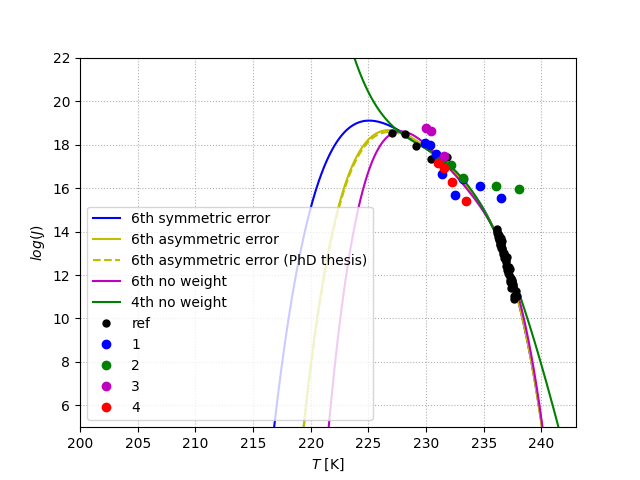

In [28]:
plt.figure()
#plt.errorbar(T_data, J_data, yerr = [J_err/2,J_err/2], color='r', ls='none', marker='o', ms =2)
#plt.errorbar(T_fit_data[J_fit_data > 0], J_fit_data[J_fit_data > 0], color='r', ls='none', marker='o', ms =5)
plt.plot(T_arr, J_fit_sym6, 'b-', label = '6th symmetric error')
plt.plot(T_arr, J_fit_asym6, 'y-', label = '6th asymmetric error')
plt.plot(T_arr, np.polyval(n6_asym_old, T_arr), 'y--', label = '6th asymmetric error (PhD thesis)')
plt.plot(T_arr, J_fit_noweight6, 'm-', label = '6th no weight')
plt.plot(T_arr, J_fit_4th_noweight, 'g-', label = '4th no weight')

plt.plot(T_fit_data, J_fit_data, color='k', ls='none', marker='o', ms =5, label = 'ref')
plt.plot(T1_MC, np.log10(J1_MC), 'bo', label = '1')
plt.plot(T2_MC, np.log10(J2_MC), 'go', label = '2')
plt.plot(T3_MC, np.log10(J3_MC), 'mo', label = '3')
plt.plot(T4_MC, np.log10(J4_MC), 'ro', label = '4')
plt.xlabel('$T$ [K]')
plt.ylabel('$log(J)$')
plt.grid(linestyle='dotted')
plt.legend(loc='lower left', prop={'size': 10})
plt.xlim(200, 243)
#plt.ylim(0, 30)
plt.ylim(5, 22)
plt.show()

In [29]:
# fit interfacial free energy to nucleation rate data
sigma_errfunc = lambda p, T, data: (np.hstack(data) - J(np.hstack(T), D_SwissFEL_fit_log(np.hstack(T)), np.polyval(p, np.hstack(T)))).flatten()
sigma_errfunc_log = lambda p, T, data: np.log10(np.abs((np.hstack(data) - J(np.hstack(T), D_SwissFEL_fit_log(np.hstack(T)), np.polyval(p, np.hstack(T)))).flatten()))
sigma_errfunc_pow = lambda p, T, data: np.sum((np.hstack(data) - J(np.hstack(T), D_SwissFEL_fit_log(np.hstack(T)), np.polyval(p, np.hstack(T))))**2)
sigma_errfunc_sym_fit = lambda p, T, n: symlog(np.power(10, np.polyval(n, T))) - symlog(J(T, D_SwissFEL_fit_log(T), np.polyval(p, T)))

# interfacial free energy - polynomial (6 degree) - lab data
p0 = [1.198100169422e-11, -1.644226732545e-8, 9.387801708449e-6, -2.854359440278e-3, +4.874466166395e-1, -4.433154987346e1, +1.677613823216e3]
[s_p6_lab, success] = optimize.leastsq(sigma_errfunc_log, p0[:], args=([T1_MC_ex, T2_MC_ex, T3_MC_ex, T4_MC_ex], [J1_MC_high_ex, J2_MC_high_ex, J3_MC_high_ex, J4_MC_high_ex]))

if success:
    print('Lab data (Mar-Dec 2020) - polynomial fit')
    print(s_p6_lab)
    print(np.polyval(s_p6_lab, T_fit_data))#, sigma_laksmono_VFT(T1), T1

# interfacial free energy - polynomial (6 degree) - lab data + Murray data (2021) + Laksmono data (2014)
#p0 = [1.19e-11, -1.64e-8, 9.38e-6, -2.85e-3, +4.87e-1, -4.43e1, +1.67e3] # from Laksmono (2014)
[s_p6, success] = optimize.leastsq(sigma_errfunc_log, p0[:], args=(T_fit_data, J_fit_data), ftol=1.49012e-08, xtol=1.49012e-01, maxfev=10000)

if success:
    print('Lab data (Mar-Dec 2020) + Murray (2021) + Laksmono (2014) - polynomial fit')
    print(s_p6)
    #print sigma_errfunc_log(p2, T1[np.where(J1 > 1e15)], J1[np.where(J1 > 1e15)])
    print(np.polyval(s_p6, T_fit_data))#, sigma_laksmono_VFT(T1), T1

#opt_params = optimize.fmin_powell(sigma_errfunc_pow, [1], args=(np.hstack(T_fit_data), np.hstack(J_fit_data),), xtol=1e-3, ftol=1e-3, disp=0)
opt_params = optimize.fmin_powell(sigma_errfunc_pow, s_p6_lab, args=(T_fit_data, J_fit_data), xtol=1e-10, ftol=1e-10, disp=1)
print(opt_params)
print(np.polyval(opt_params, T_fit_data))
# interfacial free energy - polynomial (6 degree) - lab data + Murray data (2021) + Laksmono data (2014)
p0 = [0.124/1000, 29.1/1000-273.14*0.124/1000] # from Ickes (2015)
[s_p2, success] = optimize.leastsq(sigma_errfunc_log, p0[:], args=(T_fit_data, J_fit_data))

if success:
    print('Lab data (Mar-Dec 2020) + Murray (2021) + Laksmono (2014) - linear fit')
    print(s_p2)
    #print sigma_errfunc_log(p3, T1[np.where(J1 > 1e15)], J1[np.where(J1 > 1e15)])
    print(np.polyval(s_p2, T_fit_data))#, sigma_laksmono_VFT(T1), T1

# fit interfacial free energy to nucleation rate fit
T_fit_s_low = 226
T_fit_s_high = 238
#T_fit = np.arange(228,238,0.01) # range of D-data (lower) and J data (higher)
T_fit = np.arange(T_fit_s_low,T_fit_s_high,0.01) # range of D-data (lower) and J data (higher)
[s_p2_fit, success] = optimize.leastsq(sigma_errfunc_sym_fit, p0[:], args=(T_fit, n6_asym), ftol=1.49012e-08, xtol=1.49012e-01, maxfev=10000)

if success:
    print('J fit from Niloo (6th order asym), %d-%d K - linear fit' % (T_fit_s_low, T_fit_s_high))
    print(s_p2_fit)
    #print sigma_errfunc_log(p3, T1[np.where(J1 > 1e15)], J1[np.where(J1 > 1e15)])
    print(np.polyval(s_p2_fit, T_fit_data))#, sigma_laksmono_VFT(T1), T1
    
# sigma is assumed to be a 4th order function
p0 = np.concatenate(([1e-13, -1e-11, 1e-8], s_p2_fit))
[s_p5_fit, success] = optimize.leastsq(sigma_errfunc_sym_fit, p0[:], args=(T_fit, n6_asym), ftol=1.49012e-10, xtol=1.49012e-05, maxfev=10000)

if success:
    print('J fit from Niloo (6th order asym), %d-%d K - polynomial fit')
    print(s_p5_fit)
    #print sigma_errfunc_log(p3, T1[np.where(J1 > 1e15)], J1[np.where(J1 > 1e15)])
    print(np.polyval(s_p5_fit, T_fit_data))#, sigma_laksmono_VFT(T1), T1


Lab data (Mar-Dec 2020) - polynomial fit
[ 1.19810045e-11 -1.64422665e-08  9.38780189e-06 -2.85435962e-03
  4.87446632e-01 -4.43315482e+01  1.67761452e+03]
[0.02196536 0.02197554 0.02203338 0.02207355 0.02216967 0.02222221
 0.02227756 0.0223347  0.02199773 0.02196221 0.02202962 0.0221023
 0.02218849 0.02215449 0.02226555 0.02232417 0.02201996 0.02209535
 0.02214896 0.02220189 0.02199426 0.02198615 0.02198351 0.02198054
 0.02197867 0.02197844 0.02197562 0.02197936 0.021975   0.02197625
 0.02197343 0.02197107 0.02197007 0.02196928 0.02196795 0.02196546
 0.02196474 0.02196437 0.02196546 0.02196402 0.02196378 0.02196347
 0.02196301 0.02196248 0.02196228 0.02199183 0.02198615 0.021982
 0.02197777 0.02197401 0.02197267 0.02196824 0.02196525 0.02196455
 0.02196236 0.02198403 0.02198078 0.02197959 0.02197667 0.0219746
 0.02197286 0.02197073 0.02196795 0.02196701 0.0219674  0.02196603
 0.02196494 0.02196362 0.0219634  0.02196301 0.02227146 0.02260168
 0.02281575 0.02212991 0.02244253]
Lab data 

<IPython.core.display.Javascript object>


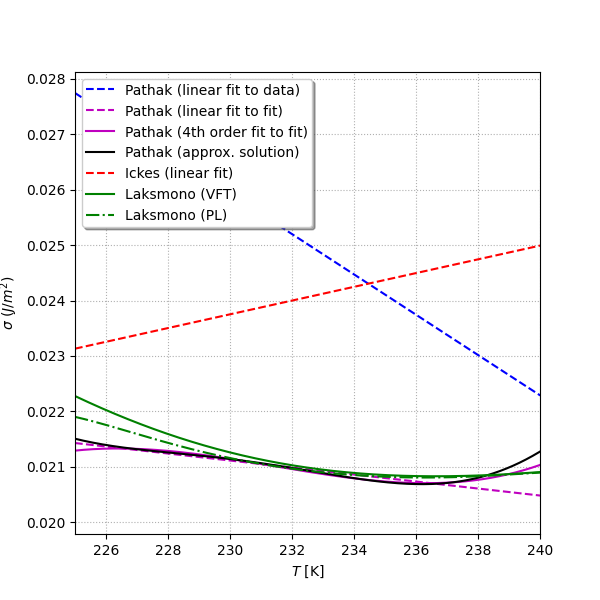

In [30]:
# plot interfacial free energy
T_arr = np.arange(225,245,0.01)

f = plt.figure(figsize=(6, 6))

#plt.title('interfacial free energy')


#plt.plot(T_arr, np.polyval(s_p6, T_arr), 'b-', label='Pathak (polynomial fit to data)')
plt.plot(T_arr, np.polyval(s_p2, T_arr), 'b--', label='Pathak (linear fit to data)')
plt.plot(T_arr, np.polyval(s_p2_fit, T_arr), 'm--', label='Pathak (linear fit to fit)')
plt.plot(T_arr, np.polyval(s_p5_fit, T_arr), 'm-', label='Pathak (4th order fit to fit)')
plt.plot(T_arr, sigma_from_J(T_arr, np.power(10, np.polyval(n6_asym, T_arr)), D_SwissFEL_fit_log(T_arr), 0.021), 'k-', label='Pathak (approx. solution)')
plt.plot(T_arr, np.polyval([0.124/1000, 29.1/1000-273.14*0.124/1000], T_arr), 'r--', label='Ickes (linear fit)')
plt.plot(T_arr, sigma_laksmono_VFT(T_arr), 'g-', label='Laksmono (VFT)')
plt.plot(T_arr, sigma_laksmono_PL(T_arr), 'g-.', label='Laksmono (PL)')
#plt.plot(T_arr, np.polyval(opt_params, T_arr), 'm-', label='Pathak (Powell opt)')
#plt.plot(T_arr, np.polyval([0.124/1000, 29.1/1000], T_arr-273.14), 'r--', label='Ickes (linear fit)')

#axes[0].plot(T_arr, D_laksmono(T_arr), 'b--', label='Laksmono (CNT fit)')
plt.xlabel('$T$ [K]')
plt.ylabel('$\sigma\ (J/m^2)$')
plt.xlim(225,240)
#axes[0].set_ylim(0.274,0.279)
plt.legend(loc='upper left',fontsize=10, fancybox=True, framealpha=1, shadow=True, borderpad=0.3)
plt.grid(linestyle='dotted')

#plt.savefig('fig4-interfacial_energy.eps', format='eps')
plt.show()

<IPython.core.display.Javascript object>


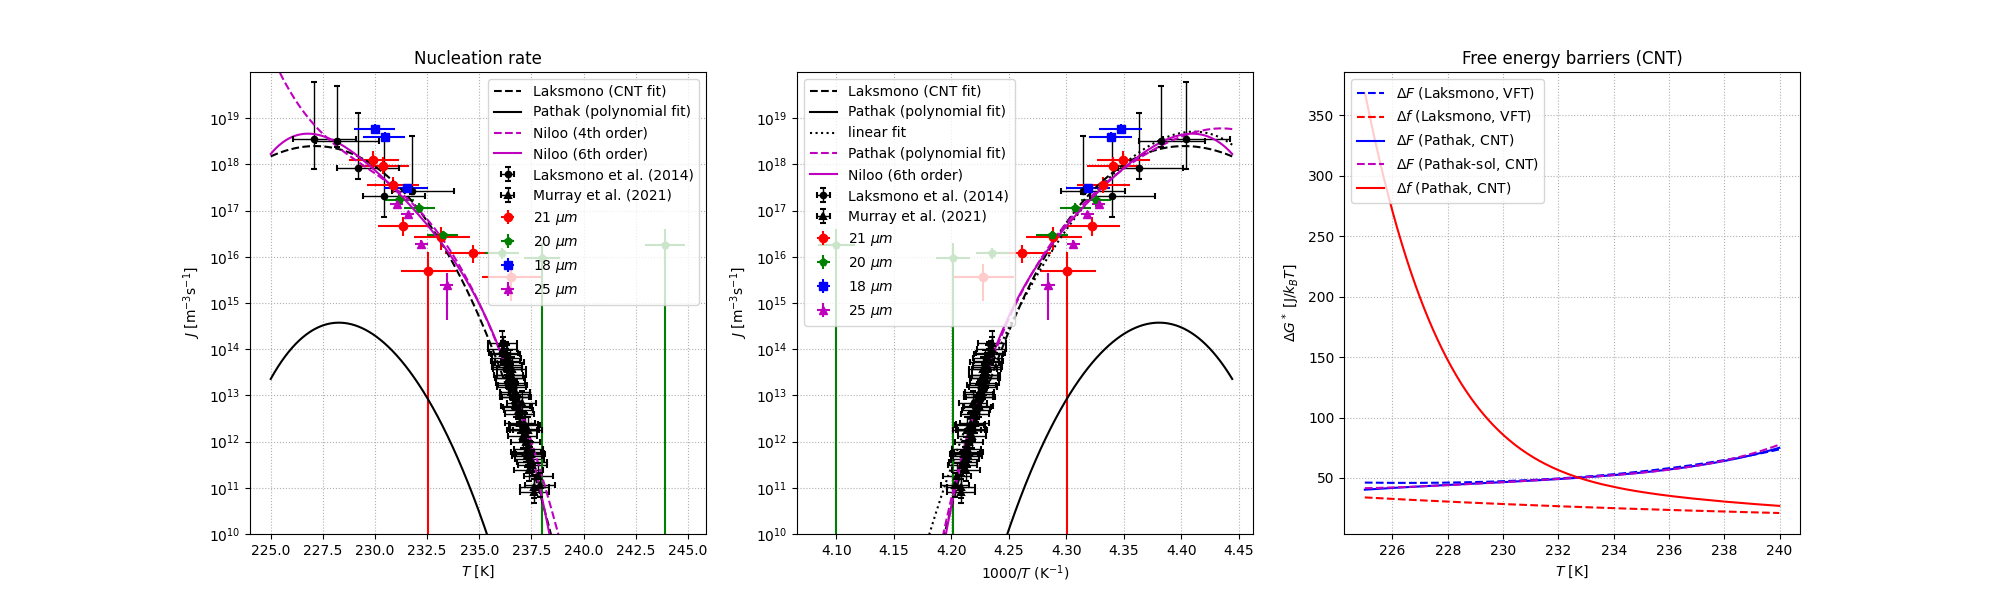

In [31]:
T_arr = np.arange(225,240,0.01)

# plot nucleation rate J and kinetic and thermodynamic free energy barrier
f, axes = plt.subplots(nrows=1, ncols=3,  figsize=(20, 6))
err_linestyle = {"linewidth":1, "markeredgewidth":1.5, "elinewidth":1, "capsize":2}

#axes[0].semilogy(T2_MC, J2_MC, 'r^:', label='Nov 2020 (MC)')
axes[0].semilogy(T_arr, J(T_arr, D_VFT(T_arr), sigma_laksmono_VFT(T_arr)), 'k--', label='Laksmono (CNT fit)')
axes[0].semilogy(T_arr, J(T_arr, D_SwissFEL_fit_log(T_arr), np.polyval(s_p6_lab, T_arr)), 'k-', label='Pathak (polynomial fit)')
axes[0].semilogy(T_arr, np.power(10, np.polyval(n4_sym, T_arr)), 'm--', label='Niloo (4th order)')
axes[0].semilogy(T_arr, np.power(10, np.polyval(n6_asym, T_arr)), 'm-', label='Niloo (6th order)')
#axes[0].semilogy(T_arr, J(T_arr, D_SwissFEL_fit_log(T_arr), np.polyval(p3, T_arr)), 'k:', label='Pathak (linear fit)')
#axes[0].semilogy(T_arr, np.power(10,np.polyval(p3, T_arr)), 'm-', label='polynomial fit (3rd order)')
#axes[0].semilogy(T_arr, np.power(10,np.polyval(p10, T_arr)), 'm--', label='polynomial fit (10th order)')
#axes[0].semilogy(T_arr, J(T_arr, D_SwissFEL_fit_log(T_arr), sigma_laksmono_VFT(T_arr)), 'm:', label='Pathak (CNT fit)')
#axes[0].semilogy(T_laksmono, J_laksmono, 'ko', label='Laksmono')
#axes[0].semilogy(T1, J1, 'ro:', label='Mar 2020')
#axes[0].errorbar(T1_MC[np.where(J1_MC > 0)], J1_MC[np.where(J1_MC > 0)], xerr=[T1_MC_low[np.where(J1_MC > 0)], T1_MC_high[np.where(J1_MC > 0)]], yerr=[J1_MC_low[np.where(J1_MC > 0)], J1_MC_high[np.where(J1_MC > 0)]] , label='Mar 2020 (MC)', fmt='rs')
#axes[0].semilogy(T2, J2, 'g^:', label='Nov 2020')
#axes[0].errorbar(T2_MC[np.where(J2_MC > 0)], J2_MC[np.where(J2_MC > 0)], xerr=[T2_MC_low[np.where(J2_MC > 0)], T2_MC_high[np.where(J2_MC > 0)]], yerr=[J2_MC_low[np.where(J2_MC > 0)], J2_MC_high[np.where(J2_MC > 0)]] , label='Nov 2020 (MC)', fmt='gs')
#axes[0].semilogy(T3, J3, 'bs:', label='Dec 2020')
#axes[0].errorbar(T3_MC[np.where(J3_MC > 0)], J3_MC[np.where(J3_MC > 0)], xerr=[T3_MC_low[np.where(J3_MC > 0)], T3_MC_high[np.where(J3_MC > 0)]], yerr=[J3_MC_low[np.where(J3_MC > 0)], J3_MC_high[np.where(J3_MC > 0)]] , label='Dec 2020 (MC)', fmt='bs')
axes[0].errorbar(T_laksmono, J_laksmono, xerr=[abs(T_laksmono_low), T_laksmono_high], yerr=[abs(J_laksmono_low), J_laksmono_high], fmt='ko', ms=4, label='Laksmono et al. (2014)', **err_linestyle)
#axes[0].errorbar(T_Ben1, J_Ben1, yerr=[J_down_Ben1, J_up_Ben1], fmt='yo', ms=4, label='Murray et al. (2010)', **err_linestyle)
#axes[0].errorbar(T_Ben2, J_Ben2, yerr=[J_down_Ben2, J_up_Ben2], fmt='yo', ms=4, **err_linestyle)
#axes[0].errorbar(T_Ben1, J_Ben1, yerr=[J_down_Ben1, J_up_Ben1], fmt='D', color='0.2', ms=4, label='Murray et al. (2010)', **err_linestyle)
#axes[0].errorbar(T_Ben2, J_Ben2, yerr=[J_down_Ben2, J_up_Ben2], fmt='D', color='0.2', ms=4, **err_linestyle)
#axes[0].errorbar(T_Murray_R1, J_Murray_R1, yerr=[J_R1_down, J_R1_up], xerr=[T_R1_err, T_R1_err], fmt='mo', ms=4, label='Murray et al. (2021)', **err_linestyle)
#axes[0].errorbar(T_Murray_R2, J_Murray_R2, yerr=[J_R2_down, J_R2_up], xerr=[T_R2_err, T_R2_err], fmt='mo', ms=4, **err_linestyle)
#axes[0].errorbar(T_Murray_R3, J_Murray_R3, yerr=[J_R3_down, J_R3_up], xerr=[T_R3_err, T_R3_err], fmt='mo', ms=4, **err_linestyle)
#axes[0].errorbar(T_Murray_R1, J_Murray_R1, yerr=[J_R1_down, J_R1_up], xerr=[T_R1_err, T_R1_err], fmt='^', color='0.8', ms=4, label='Murray et al. (2021)', **err_linestyle)
axes[0].errorbar(T_Murray_R1, J_Murray_R1, yerr=[J_R1_down, J_R1_up], xerr=[T_R1_err, T_R1_err], fmt='^', color='k', ms=4, label='Murray et al. (2021)', **err_linestyle)
axes[0].errorbar(T_Murray_R2, J_Murray_R2, yerr=[J_R2_down, J_R2_up], xerr=[T_R2_err, T_R2_err], fmt='^', color='k', ms=4, **err_linestyle)
axes[0].errorbar(T_Murray_R3, J_Murray_R3, yerr=[J_R3_down, J_R3_up], xerr=[T_R3_err, T_R3_err], fmt='^', color='k', ms=4, **err_linestyle)
axes[0].errorbar(T1_MC[np.where(J1_MC > 0)], J1_MC[np.where(J1_MC > 0)], xerr=[T1_MC_low[np.where(J1_MC > 0)], T1_MC_high[np.where(J1_MC > 0)]], yerr=[J1_MC_low[np.where(J1_MC > 0)], J1_MC_high[np.where(J1_MC > 0)]] , label='%.0f $\mu m$' % (d1[0]*1e6), fmt='ro')
axes[0].errorbar(T2_MC[np.where(J2_MC > 0)], J2_MC[np.where(J2_MC > 0)], xerr=[T2_MC_low[np.where(J2_MC > 0)], T2_MC_high[np.where(J2_MC > 0)]], yerr=[J2_MC_low[np.where(J2_MC > 0)], J2_MC_high[np.where(J2_MC > 0)]] , label='%.0f $\mu m$' % (d2[0]*1e6), fmt='gp')
axes[0].errorbar(T3_MC[np.where(J3_MC > 0)], J3_MC[np.where(J3_MC > 0)], xerr=[T3_MC_low[np.where(J3_MC > 0)], T3_MC_high[np.where(J3_MC > 0)]], yerr=[J3_MC_low[np.where(J3_MC > 0)], J3_MC_high[np.where(J3_MC > 0)]] , label='%.0f $\mu m$' % (d3[0]*1e6), fmt='bs')
axes[0].errorbar(T4_MC[np.where(J4_MC > 0)], J4_MC[np.where(J4_MC > 0)], xerr=[T4_MC_low[np.where(J4_MC > 0)], T4_MC_high[np.where(J4_MC > 0)]], yerr=[J4_MC_low[np.where(J4_MC > 0)], J4_MC_high[np.where(J4_MC > 0)]] , label='%.0f $\mu m$' % (d4[0]*1e6), fmt='m^')
axes[0].legend(loc='upper right', prop={'size': 10})
axes[0].set_xlabel('$T$ [K]')
axes[0].set_ylabel('$J$ [m$^{-3}$s$^{-1}$]')
axes[0].set_title('Nucleation rate')
#axes[0].set_xlim(170,310)
axes[0].set_ylim(1e10,1e20)
axes[0].set_yscale('symlog')
axes[0].grid(linestyle='dotted')

axes[1].semilogy(1000/T_arr, J(T_arr, D_VFT(T_arr), sigma_laksmono_VFT(T_arr)), 'k--', label='Laksmono (CNT fit)')
axes[1].semilogy(1000/T_arr, J(T_arr, D_SwissFEL_fit_log(T_arr), np.polyval(s_p6_lab, T_arr)), 'k-', label='Pathak (polynomial fit)')
axes[1].semilogy(1000/T_arr, J(T_arr, D_SwissFEL_fit_log(T_arr), np.polyval(s_p2_fit, T_arr)), 'k:', label='linear fit')
axes[1].semilogy(1000/T_arr, J(T_arr, D_SwissFEL_fit_log(T_arr), np.polyval(s_p5_fit, T_arr)), 'm--', label='Pathak (polynomial fit)')
axes[1].semilogy(1000/T_arr, np.power(10, np.polyval(n6_asym, T_arr)), 'm-', label='Niloo (6th order)')
#axes[1].semilogy(1000/T_arr, J(T_arr, D_SwissFEL_fit_log(T_arr), sigma_from_J(T_arr, np.power(10, np.polyval(n6_asym, T_arr)), D_SwissFEL_fit_log(T_arr), 0.021)), 'g--', label='Pathak (approx. solution)')
axes[1].errorbar(1000/T_laksmono, J_laksmono, xerr=[abs(T_laksmono_low*1000/T_laksmono/T_laksmono), T_laksmono_high*1000/T_laksmono/T_laksmono], yerr=[abs(J_laksmono_low), J_laksmono_high], fmt='ko', ms=4, label='Laksmono et al. (2014)', **err_linestyle)
#axes[1].errorbar(1000/T_Ben1, J_Ben1, yerr=[J_down_Ben1, J_up_Ben1], fmt='D', color='0.2', ms=4, label='Murray et al. (2010)', **err_linestyle)
#axes[1].errorbar(1000/T_Ben2, J_Ben2, yerr=[J_down_Ben2, J_up_Ben2], fmt='D', color='0.2', ms=4, **err_linestyle)
#axes[1].errorbar(1000/T_Murray_R1, J_Murray_R1, yerr=[J_R1_down, J_R1_up], xerr=[1000*T_R1_err/T_Murray_R1/T_Murray_R1, 1000*T_R1_err/T_Murray_R1/T_Murray_R1], fmt='^', color='0.8', ms=4, label='Murray et al. (2021)', **err_linestyle)
axes[1].errorbar(1000/T_Murray_R1, J_Murray_R1, yerr=[J_R1_down, J_R1_up], xerr=[1000*T_R1_err/T_Murray_R1/T_Murray_R1, 1000*T_R1_err/T_Murray_R1/T_Murray_R1], fmt='^', color='k', ms=4, label='Murray et al. (2021)', **err_linestyle)
axes[1].errorbar(1000/T_Murray_R2, J_Murray_R2, yerr=[J_R2_down, J_R2_up], xerr=[1000*T_R2_err/T_Murray_R2/T_Murray_R2, 1000*T_R2_err/T_Murray_R2/T_Murray_R2], fmt='^', color='k', ms=4, **err_linestyle)
axes[1].errorbar(1000/T_Murray_R3, J_Murray_R3, yerr=[J_R3_down, J_R3_up], xerr=[1000*T_R3_err/T_Murray_R3/T_Murray_R3, 1000*T_R3_err/T_Murray_R3/T_Murray_R3], fmt='^', color='k', ms=4, **err_linestyle)
axes[1].errorbar(1000/T1_MC[np.where(J1_MC > 0)], J1_MC[np.where(J1_MC > 0)], xerr=[1000*T1_MC_low[np.where(J1_MC > 0)]/T1_MC[np.where(J1_MC > 0)]/T1_MC[np.where(J1_MC > 0)], 1000*T1_MC_high[np.where(J1_MC > 0)]/T1_MC[np.where(J1_MC > 0)]/T1_MC[np.where(J1_MC > 0)]], yerr=[J1_MC_low[np.where(J1_MC > 0)], J1_MC_high[np.where(J1_MC > 0)]] , label='%.0f $\mu m$' % (d1[0]*1e6), fmt='ro')
axes[1].errorbar(1000/T2_MC[np.where(J2_MC > 0)], J2_MC[np.where(J2_MC > 0)], xerr=[1000*T2_MC_low[np.where(J2_MC > 0)]/T2_MC[np.where(J2_MC > 0)]/T2_MC[np.where(J2_MC > 0)], 1000*T2_MC_high[np.where(J2_MC > 0)]/T2_MC[np.where(J2_MC > 0)]/T2_MC[np.where(J2_MC > 0)]], yerr=[J2_MC_low[np.where(J2_MC > 0)], J2_MC_high[np.where(J2_MC > 0)]] , label='%.0f $\mu m$' % (d2[0]*1e6), fmt='gp')
axes[1].errorbar(1000/T3_MC[np.where(J3_MC > 0)], J3_MC[np.where(J3_MC > 0)], xerr=[1000*T3_MC_low[np.where(J3_MC > 0)]/T3_MC[np.where(J3_MC > 0)]/T3_MC[np.where(J3_MC > 0)], 1000*T3_MC_high[np.where(J3_MC > 0)]/T3_MC[np.where(J3_MC > 0)]/T3_MC[np.where(J3_MC > 0)]], yerr=[J3_MC_low[np.where(J3_MC > 0)], J3_MC_high[np.where(J3_MC > 0)]] , label='%.0f $\mu m$' % (d3[0]*1e6), fmt='bs')
axes[1].errorbar(1000/T4_MC[np.where(J4_MC > 0)], J4_MC[np.where(J4_MC > 0)], xerr=[1000*T4_MC_low[np.where(J4_MC > 0)]/T4_MC[np.where(J4_MC > 0)]/T4_MC[np.where(J4_MC > 0)], 1000*T4_MC_high[np.where(J4_MC > 0)]/T4_MC[np.where(J4_MC > 0)]/T4_MC[np.where(J4_MC > 0)]], yerr=[J4_MC_low[np.where(J4_MC > 0)], J4_MC_high[np.where(J4_MC > 0)]] , label='%.0f $\mu m$' % (d4[0]*1e6), fmt='m^')
axes[1].legend(loc='upper left', prop={'size': 10})
axes[1].set_ylim(1e10,1e20)
axes[1].set_xlabel('$1000/T$ (K$^{-1}$)')
axes[1].set_ylabel('$J$ [m$^{-3}$s$^{-1}$]')
axes[1].set_yscale('symlog')
axes[1].grid(linestyle='dotted')

axes[2].plot(T_arr, deltaF(T_arr, sigma_laksmono_VFT(T_arr))/kB/T_arr, 'b--', label='$\Delta F$ (Laksmono, VFT)')
axes[2].plot(T_arr, deltaf(T_arr, D_VFT(T_arr))/kB/T_arr, 'r--', label='$\Delta f$ (Laksmono, VFT)')
axes[2].plot(T_arr, deltaF(T_arr, np.polyval(s_p5_fit, T_arr))/kB/T_arr, 'b-', label='$\Delta F$ (Pathak, CNT)')
axes[2].plot(T_arr, deltaF(T_arr, sigma_from_J(T_arr, np.power(10, np.polyval(n6_asym, T_arr)), D_SwissFEL_fit_log(T_arr), 0.021))/kB/T_arr, 'm--', label='$\Delta F$ (Pathak-sol, CNT)')
axes[2].plot(T_arr, deltaf(T_arr, D_SwissFEL_fit_log(T_arr))/kB/T_arr, 'r-', label='$\Delta f$ (Pathak, CNT)')
axes[2].legend(loc='upper left', prop={'size': 10})
#axes[2].set_xlim(228,238)
axes[2].set_xlabel('$T$ [K]')
axes[2].set_ylabel('$\Delta G^*$ [J/$k_B T$]')
axes[2].set_title('Free energy barriers (CNT)')
axes[2].grid(linestyle='dotted')

#plt.savefig('-nucleation_rate.eps', format='eps')
plt.show()

In [32]:
def reactions(k, marbles, blobs, fractured):
    dmdt = -(k[0] + k[2])*np.array(marbles)
    dbdt = k[0]*np.array(marbles) - k[1]*np.array(blobs)
    dcdt = k[2]*np.array(marbles) + k[1]*np.array(blobs)
    return np.array([dmdt, dbdt, dcdt])
    
errfunc = lambda k, t, marbles, blobs, fractured: (reactions(k, marbles, blobs, fractured) - np.array([np.gradient(marbles, t), np.gradient(blobs, t), np.gradient(fractured, t)])).flatten()

# reaction rates - estimated from last 3 data points where ice fraction increases significantly
k0 = [0.6, 0.5, 0.4] # initial guess
[k1, success] = optimize.leastsq(errfunc, k0[:], args=(time1*1000, nmarbles1, nblobs1, nfract1+ndist1))

if success:
    print('March 2020 - all data - raw counts')
    print(k1)

[k1, success] = optimize.leastsq(errfunc, k0[:], args=(time1[-3:]*1000, nmarbles1[-3:], nblobs1[-3:], nfract1[-3:]+ndist1[-3:]))

if success:
    print('March 2020 - last 3 data points (>10% ice) - raw counts')
    print(k1)

[k1, success] = optimize.leastsq(errfunc, k0[:], args=(time1[-3:]*1000, fmarbles1[-3:], fblobs1[-3:], ffract1[-3:]+fdist1[-3:]))

if success:
    print('March 2020 - last 3 data points (>10% ice) - normalized')
    print(k1)

March 2020 - all data - raw counts
[ 1.36903255 -0.87391516  0.19790447]
March 2020 - last 3 data points (>10% ice) - raw counts
[ 1.29645648 -0.95669573  0.26763431]
March 2020 - last 3 data points (>10% ice) - normalized
[ 1.82349332 -0.80827195 -0.1086273 ]


In [33]:
# exclude stray points from J for reaction rates?

In [34]:
def reactions(k, marbles, blobs, fractured, J, water):
    # time derivatives form rate equations
    dmdt = J*np.array(water) - (k[0] + k[2])*np.array(marbles) # marbles
    dbdt = k[0]*np.array(marbles) - k[1]*np.array(blobs) # blobs
    dcdt = k[2]*np.array(marbles) + k[1]*np.array(blobs) # fractured
    return np.array([dmdt, dbdt, dcdt])

def derivatives(t, marbles, blobs, fractured, setindex):
    return np.array([np.hstack([np.gradient(marbles[setindex[j-1]:setindex[j]], t[setindex[j-1]:setindex[j]]) if (j > 0) else np.gradient(marbles[:setindex[j]], t[:setindex[j]]) for j in range(len(setindex))]), np.hstack([np.gradient(blobs[setindex[j-1]:setindex[j]], t[setindex[j-1]:setindex[j]]) if (j > 0) else np.gradient(blobs[:setindex[j]], t[:setindex[j]]) for j in range(len(setindex))]), np.hstack([np.gradient(fractured[setindex[j-1]:setindex[j]], t[setindex[j-1]:setindex[j]]) if (j > 0) else np.gradient(fractured[:setindex[j]], t[:setindex[j]]) for j in range(len(setindex))])])

#errfunc = lambda k, t, marbles, blobs, fractured, J, water: (reactions(k, marbles, blobs, fractured, J, water) - np.array([np.gradient(marbles, t), np.gradient(blobs, t), np.gradient(fractured, t)])).flatten()
def errfunc(k, t, marbles, blobs, fractured, J, water, setindex=None):
    #if len(t.shape) > 1:
    #if isinstance(t[0], np.ndarray):
        #return (np.hstack([reactions(k, marbles[j], blobs[j], fractured[j], J[j], water[j]) for j in range(len(t))]) - np.hstack([[np.gradient(marbles[j], t[j]), np.gradient(blobs[j], t[j]), np.gradient(fractured[j], t[j])] for j in range(len(t))])))
    if setindex is not None:
        #print('hstack deluxe')
        return (reactions(k, marbles, blobs, fractured, J, water) - derivatives(t, marbles, blobs, fractured, setindex=setindex)).flatten()
    else:
        #print('gradient style')
        return (reactions(k, marbles, blobs, fractured, J, water) - np.array([np.gradient(marbles, t), np.gradient(blobs, t), np.gradient(fractured, t)])).flatten()

k0 = [3.*1000, 0.5*1000, 3.*1000] # initial guess

[k1, success] = optimize.leastsq(errfunc, k0[:], args=(time1, fmarbles1, fblobs1, ffract1+fdist1, J1_MC*V1, (1-fice1)))
if success:
    print('March 2020 - all data')
    print(k1/1000, 'fraction rate per droplet per ms')
    print('residuals per data point:', np.mean(errfunc(k1, time1, fmarbles1, fblobs1, ffract1+fdist1, J1_MC*V1, (1-fice1))**2))
    print('')
    
[k1, success] = optimize.leastsq(errfunc, k0[:], args=(time1[-3:], fmarbles1[-3:], fblobs1[-3:], ffract1[-3:]+fdist1[-3:], J1_MC[-3:]*V1, (1-fice1)[-3:]))
if success:
    print('March 2020 - last 3 data points (>10% ice)')
    print(k1/1000, 'fraction rate per droplet per ms')
    print('residuals per data point:', np.mean(errfunc(k1, time1, fmarbles1, fblobs1, ffract1+fdist1, J1_MC*V1, (1-fice1))**2))
    print('')

[k2, success] = optimize.leastsq(errfunc, k0[:], args=(time2, fmarbles2, fblobs2, ffract2+fdist2, J2_MC*V2, (1-fice2)))
if success:
    print('Nov 2020 - all data')
    print(k2/1000, 'fraction rate per droplet per ms')
    print('residuals per data point:', np.mean(errfunc(k2, time2, fmarbles2, fblobs2, ffract2+fdist2, J2_MC*V2, (1-fice2))**2))
    print('')
    
[k3, success] = optimize.leastsq(errfunc, k0[:], args=(time3, fmarbles3[:-1], fblobs3[:-1], ffract3[:-1], J3_MC*V3, (1-fice3)))
if success:
    print('Dec 2020 - all data')
    print(k3/1000, 'fraction rate per droplet per ms')
    print('residuals per data point:', np.mean(errfunc(k3, time3, fmarbles3[:-1], fblobs3[:-1], ffract3[:-1], J3_MC*V3, (1-fice3))**2))
    print('')

[k, success] = optimize.leastsq(errfunc, k3[:], args=(time, fmarbles, fblobs, ffractdist, G, (1-fice), setindex))
if success:
    print('March+Nov+Dec 2020 + May 2021 - all data')
    print(k/1000, 'fraction rate per droplet per ms')
    print('residuals per data point:', np.mean(errfunc(k, time, fmarbles, fblobs, ffractdist, G, (1-fice), setindex)**2))
    print('')

March 2020 - all data
[ 3.61461553 -0.79367091  1.79807974] fraction rate per droplet per ms
residuals per data point: 24779.070195835084

March 2020 - last 3 data points (>10% ice)
[ 3.63495274 -0.80827181  1.70283153] fraction rate per droplet per ms
residuals per data point: 24868.44042207209

Nov 2020 - all data
[ 1.7753653  -0.52893762  2.72781548] fraction rate per droplet per ms
residuals per data point: 7531.210326049062

Dec 2020 - all data
[ 9.78407287 -0.70302578  4.41243196] fraction rate per droplet per ms
residuals per data point: 3171024.37034821

March+Nov+Dec 2020 + May 2021 - all data
[ 2.97345123 -1.07107208  1.40429445] fraction rate per droplet per ms
residuals per data point: 784614.451758404



<IPython.core.display.Javascript object>


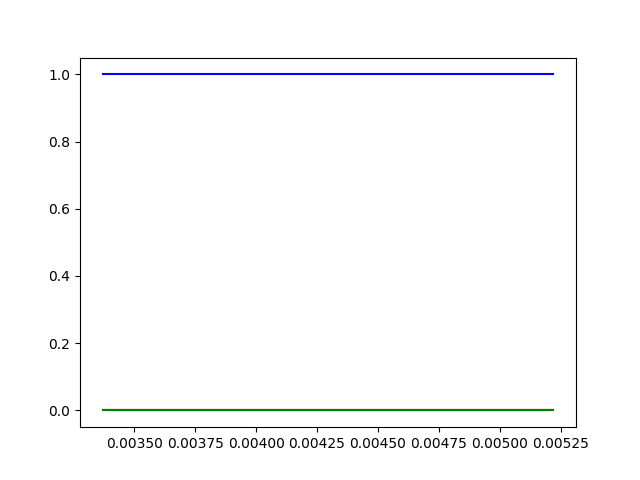

In [35]:
# relevant time to our experiment
#t_model = np.linspace(3.37/1000, 4.22/1000, num=500)
t_model = np.linspace(3.37/1000, 5.22/1000, num=500)
# initial values
init = np.array([1.0, 0., 0., 0.])

# k calculated
k_vals = np.array([k[0],k[1],k[2]])

# m, b, linear fit to ln(J) vs time [ms], first 2 points
J_vals = slope_and_intercept(time3[:2]*1000, np.log(J3_MC[:2]))

# m, b, linear fit to ln(J) vs time [ms], all points
#J_vals = slope_and_intercept(time3*1000, np.log(J3_MC))

w,m,b,f = rate_model(init, k_vals, J_vals, V3, t_model)

plt.figure()
plt.plot(t_model, w, 'b')
plt.plot(t_model, m, 'r')
plt.plot(t_model, b, 'y')
plt.plot(t_model, f, 'g')

<IPython.core.display.Javascript object>


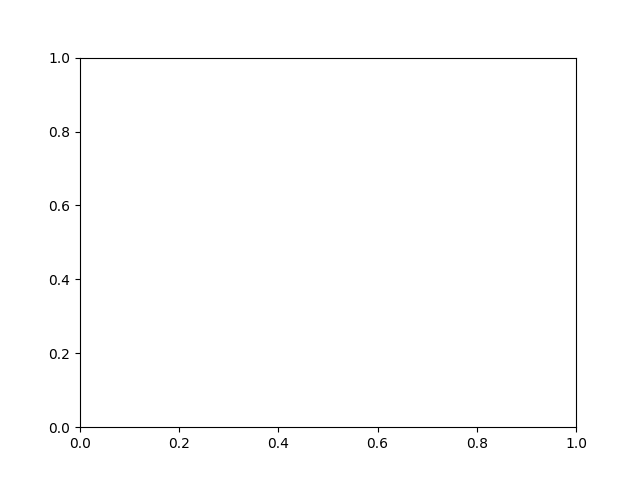

<IPython.core.display.Javascript object>


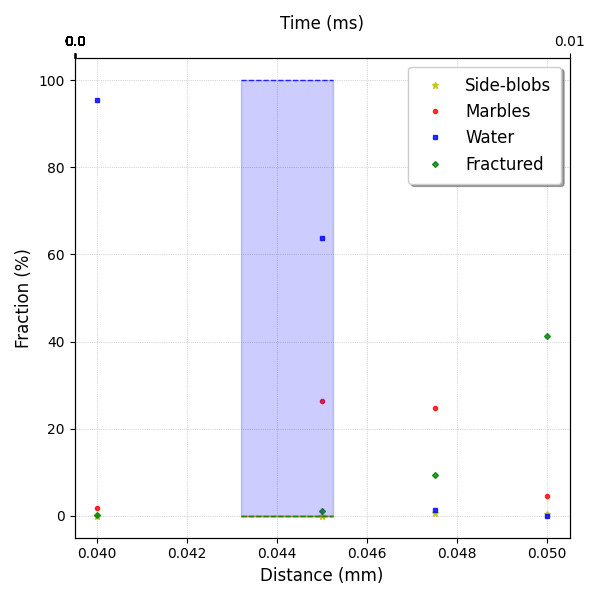

In [38]:
fig, ax = plt.subplots()

fig, ax1 = plt.subplots(figsize=(6,6))

t_ax = np.round(time, 2)

ax1.plot(distance3, nblobs3/ntot3, 'y*', ms=5, label = 'Side-blobs', alpha=0.8)
ax1.plot(distance3, nmarbles3/ntot3*100.0, 'ro', ms=3, label = 'Marbles', alpha=0.8)
ax1.plot(distance3, nwater3/ntot3*100.0, 'bs', ms=3, label = 'Water', alpha=0.8)
ax1.plot(distance3, nfract3/ntot3*100.0, 'gD', ms=3, label= 'Fractured', alpha=0.8)


ax1.set_xlabel('Distance (mm)', fontsize=12)
for label in ax1.get_xticklabels():
    label.set_color("k")

    
    
y2 = 0    
ax2 = ax1.twiny()
ax2.plot(time, fice*100, lw=0.000001, alpha=0.00001) 

ax2.fill_between(t_model, w*100., y2, color= 'b', alpha=0.2)
ax2.fill_between(t_model, b*100., y2, color= 'y', alpha=0.2) 
ax2.fill_between(t_model, f*100., y2, color= 'g', alpha=0.2)
ax2.fill_between(t_model, m*100., y2, color= 'r', alpha=0.2)
ax2.plot(t_model, m*100., 'r--', lw=1, alpha=0.8)
ax2.plot(t_model, w*100., 'b--', lw=1, alpha=0.8)
ax2.plot(t_model, b*100., 'y--', lw=1, alpha=0.8)
ax2.plot(t_model, f*100., 'g--', lw=1, alpha=0.8)
ax2.set_xlabel('Time (ms)', fontsize=12)
for label in ax2.get_xticklabels():
    label.set_color("k")

ax2.set_xticks(t_ax) 
ax2.set_xticklabels(t_ax, fontsize=10)

ax1.set_ylabel('Fraction (%)', fontsize = 12)
ax1.legend(loc='upper right',fontsize=12, fancybox=True, framealpha=1., shadow=True, borderpad=0.6)
ax1.grid(linestyle='dotted', lw=0.5)
plt.tight_layout()
#plt.savefig('/Users/niloo/Desktop/manuscript/ice_fraction/fig3/test_icefractions.eps')
plt.show()
